### Monte Carlo Release-Recapture Temperatures

In [1]:
using BeamPropagation, 
    Distributions, 
    UnitsToValue,
    StatsBase, 
    StaticArrays, 
    Plots,
    StructArrays,
    MutableNamedTuples,
    PhysicalConstants.CODATA2018,
    LinearAlgebra

In [2]:
# Define physical constants
const kB = BoltzmannConstant.val
const T = @with_unit 30 "μK"

# Define molecule parameters for CaOH
const m = @with_unit 57 "u"
const v_recoil = @with_unit 1.1 "cm/s"
;

In [3]:
# Define tweezer beam properties
const T_depth = @with_unit 1.4 "mK"
const U_max = kB * T_depth
const λ = 780e-9
const w0x = 2.0e-6
const w0y = 2.0e-6

# Create an instance of a gaussian trap for the tweezer
trap = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m)
;

In [4]:
total_time = @with_unit 5000 "μs"               
release_start_time = @with_unit 2000 "μs"        
release_end_time = @with_unit 2020 "μs"         
;

In [49]:
n = 10000
save_every = 100
delete_every = 50
dt_min = 1e-10
dt_max = 1e-4
abstol = 1e-5
dt = 1e-7
max_steps = Int64(ceil(total_time / dt))
alg = "rkf12"
use_adaptive = false
dt0 = 1e-5
times = (0:dt:max_steps * dt)[1:save_every:end-1]
;

In [50]:
discard(r, v) = false
is_detectable(r, trap) = (abs(r[1]) < 5trap.w0x) && (abs(r[2]) < 5trap.w0y) && (abs(r[3]) < 5max(trap.zRx, trap.zRy))

function update(particles, p, s, dt, time, idx)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        r = particles.r[i]
        s.detectable[idx] = is_detectable(r, p.trap)
    end
    return nothing
end

gravity(r) = SVector(0.0, -9.81, 0.0)

function f(idx, r, v, p, time)
    if p.release_start_time < time < p.release_end_time
        U_depth = 0.0
    else
        U_depth = p.trap.U_max
    end
    return F(r, p.trap) * U_depth / m + gravity(r)
end

function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        push!(s.trajectories[idx], particles.r[i])
    end
    return nothing
end
;

In [51]:
detectable = zeros(Bool, n)

particles = StructArray{Particle}(undef, n)
trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]

r, v, a = make_distributions(T, trap)

p = @params (trap, release_start_time, release_end_time)
s = @params (detectable, trajectories)

@time propagate_particles!(r, v, a, 
    alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true
)
mean(s.detectable) |> display

 10.000968 seconds (156.20 k allocations: 225.059 MiB, 17.10% gc time, 21.10% compilation time: 10% of which was recompilation)


0.337

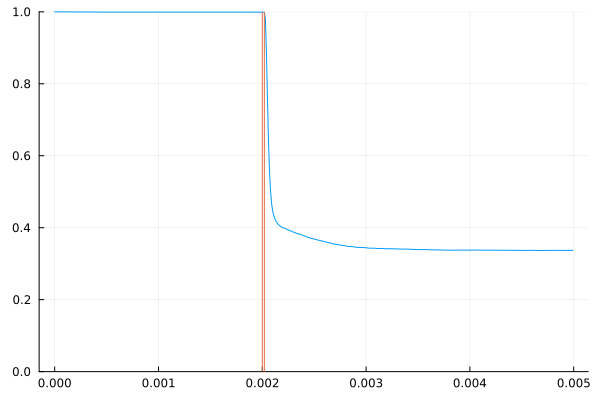

In [52]:
survival = vec(mean(mapreduce(permutedims, vcat, [[is_detectable(s.trajectories[i][j], trap) for j ∈ 1:length(times)] for i ∈ 1:n]), dims=1))
plot(times, survival, legend=nothing)
plot!(ylim=(0,1))
vline!([release_start_time, release_end_time])

## Scan in-trap temperature to fit to data

In [53]:
data_xs = 1e-6 .* [
    2
    4
    6
    8
    10
    12
    14
    20
    24
    30
    34
    40
    50
]

data_ys = [
    0.531969309462916
    0.418831168831169
    0.454545454545455
    0.355072463768116
    0.293706293706294
    0.212121212121212
    0.198529411764706
    0.0942028985507246
    0.153846153846154
    0.0977443609022556
    0.0597014925373134
    0.0534351145038168
    0.0238095238095238
]
;

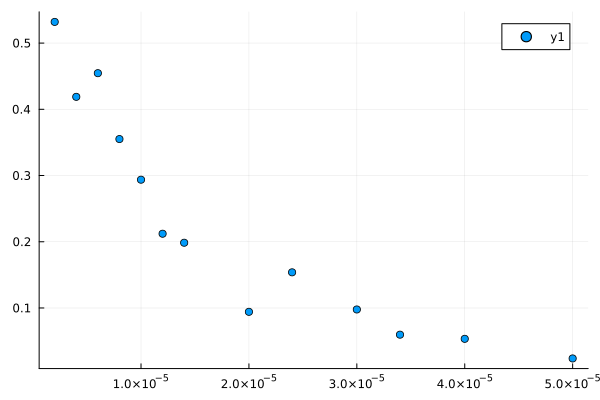

In [54]:
scatter(data_xs, data_ys)

In [59]:
data_xs_finer = (0:1.0:50) * 1e-6
;

In [60]:
# Create a release-recapture plot for a single temperature
const T = T_depth / 6.5
r, v, a = make_distributions(T, trap)
# release_durations = deepcopy(data_xs)
release_durations = data_xs_finer

surviving_fractions = zeros(length(release_durations))
for (i, release_duration) ∈ enumerate(release_durations)

    # Reset parameters for current run
    p.release_start_time = release_start_time
    p.release_end_time = release_start_time + release_duration
    
    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    surviving_fractions[i] = mean(s.detectable)
end

  7.442271 seconds (40.48 k allocations: 217.336 MiB)
  7.367740 seconds (40.60 k allocations: 217.347 MiB)
  7.499183 seconds (40.59 k allocations: 217.347 MiB)
 24.150285 seconds (40.53 k allocations: 217.338 MiB, 51.42% gc time)
  7.730991 seconds (40.61 k allocations: 217.347 MiB)
  7.577006 seconds (40.59 k allocations: 217.347 MiB)
  7.999332 seconds (40.60 k allocations: 217.347 MiB)
  7.868481 seconds (40.60 k allocations: 217.347 MiB)
  7.781297 seconds (40.71 k allocations: 217.357 MiB)
  7.739193 seconds (40.59 k allocations: 217.347 MiB)
  8.065777 seconds (40.60 k allocations: 217.347 MiB)
  8.166629 seconds (40.59 k allocations: 217.347 MiB)
 18.471429 seconds (40.66 k allocations: 217.348 MiB, 35.97% gc time)
  7.776863 seconds (40.71 k allocations: 217.357 MiB)
  7.873849 seconds (40.71 k allocations: 217.357 MiB)
  8.122516 seconds (40.59 k allocations: 217.347 MiB)
  7.911221 seconds (40.59 k allocations: 217.347 MiB)
  7.957201 seconds (40.72 k allocations: 217.357 M

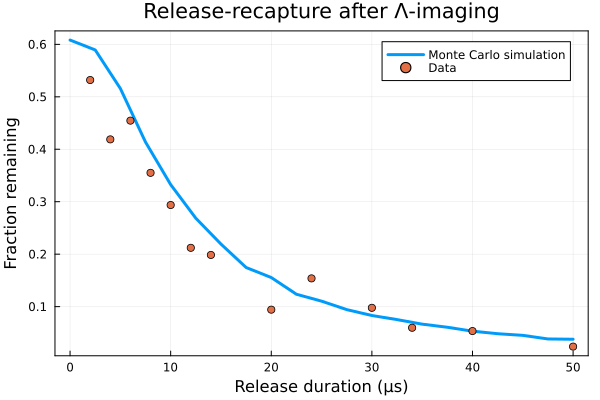

In [61]:
plot(release_durations .* 1e6, 0.62 * surviving_fractions,
    title="Release-recapture after Λ-imaging",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [ ]:
ηs = 3:0.5:11
Ts = T_depth ./ ηs

release_durations = data_xs
surviving_fractions = Vector{Float64}[]

iter = Ts
for (i, T) ∈ enumerate(Ts)
    display(ηs[i])
    r, v, a = make_distributions(T, trap)
    surviving_fraction = zeros(length(release_durations))

    for (j, release_duration) ∈ enumerate(release_durations)

        # Reset parameters for current run
        p.release_start_time = release_start_time
        p.release_end_time = release_start_time + release_duration

        particles = StructArray{Particle}(undef, n)
        detectable = zeros(Bool, n)
        trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
        s = @params (detectable, trajectories)

        @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
            dt_min, dt_max, abstol, true)

        surviving_fraction[j] = mean(s.detectable)
        
    end
    push!(surviving_fractions, surviving_fraction) 
end

3.0

 16.929110 seconds (40.47 k allocations: 217.336 MiB, 55.24% gc time)
  7.577582 seconds (40.59 k allocations: 217.347 MiB)
  7.660404 seconds (40.58 k allocations: 217.346 MiB)
  7.711533 seconds (40.59 k allocations: 217.347 MiB)
  7.738618 seconds (40.59 k allocations: 217.347 MiB)
  7.741316 seconds (40.59 k allocations: 217.347 MiB)
  7.887963 seconds (40.58 k allocations: 217.347 MiB)
  8.179379 seconds (40.59 k allocations: 217.347 MiB)
  8.313604 seconds (40.60 k allocations: 217.347 MiB)
 26.071058 seconds (40.66 k allocations: 217.348 MiB, 56.43% gc time)
  7.800705 seconds (40.60 k allocations: 217.347 MiB)
  7.922849 seconds (40.59 k allocations: 217.347 MiB)
  7.904381 seconds (40.59 k allocations: 217.347 MiB)


3.5

  7.825253 seconds (40.48 k allocations: 217.337 MiB)
  7.751916 seconds (40.59 k allocations: 217.347 MiB)
  8.055772 seconds (40.60 k allocations: 217.347 MiB)
  8.911060 seconds (40.59 k allocations: 217.347 MiB)
 10.543054 seconds (40.59 k allocations: 217.347 MiB)
 25.192309 seconds (40.54 k allocations: 217.337 MiB, 41.67% gc time)
 81.407393 seconds (40.65 k allocations: 217.348 MiB)
270.996257 seconds (40.64 k allocations: 217.348 MiB)
279.694286 seconds (40.65 k allocations: 217.348 MiB)
165.274616 seconds (41.03 k allocations: 217.355 MiB)
325.988844 seconds (40.69 k allocations: 217.349 MiB)
329.722630 seconds (40.77 k allocations: 217.358 MiB)
345.166795 seconds (40.71 k allocations: 217.349 MiB)


4.0

360.178470 seconds (40.51 k allocations: 217.337 MiB)
318.849481 seconds (40.76 k allocations: 217.358 MiB)
321.150945 seconds (40.65 k allocations: 217.348 MiB)
385.866655 seconds (40.65 k allocations: 217.348 MiB)
338.994750 seconds (40.67 k allocations: 217.349 MiB)
342.989472 seconds (40.77 k allocations: 217.351 MiB)
336.775481 seconds (40.61 k allocations: 217.347 MiB)
380.135054 seconds (40.73 k allocations: 217.349 MiB)
340.817029 seconds (40.69 k allocations: 217.349 MiB)
383.907663 seconds (40.79 k allocations: 217.352 MiB)
375.049853 seconds (40.68 k allocations: 217.349 MiB)
151.597226 seconds (40.61 k allocations: 217.347 MiB, 16.87% gc time)


4.5

  8.373470 seconds (40.59 k allocations: 217.347 MiB)
  7.843782 seconds (40.60 k allocations: 217.347 MiB)
  7.619593 seconds (40.59 k allocations: 217.347 MiB)
  7.521124 seconds (40.47 k allocations: 217.337 MiB)
  7.833852 seconds (40.71 k allocations: 217.357 MiB)
  8.048905 seconds (40.71 k allocations: 217.357 MiB)
  7.866245 seconds (40.59 k allocations: 217.347 MiB)
  7.898583 seconds (40.58 k allocations: 217.347 MiB)
 18.835107 seconds (40.59 k allocations: 217.347 MiB, 57.41% gc time)
  8.420071 seconds (40.59 k allocations: 217.347 MiB)
  9.202979 seconds (40.72 k allocations: 217.357 MiB)
 10.236956 seconds (40.58 k allocations: 217.347 MiB)
 10.651596 seconds (40.59 k allocations: 217.347 MiB)
 10.667057 seconds (40.59 k allocations: 217.347 MiB)


5.0

175.067193 seconds (40.57 k allocations: 217.339 MiB)
228.409224 seconds (40.59 k allocations: 217.347 MiB)
  9.505719 seconds (40.60 k allocations: 217.347 MiB)
 29.930228 seconds (40.68 k allocations: 217.348 MiB, 51.81% gc time)
  9.024504 seconds (40.63 k allocations: 217.347 MiB)


LoadError: InterruptException:

In [24]:
χ²(data, preds) = sum((data .- preds).^2 ./ 0.04^2);

In [25]:
function model_with_best_scaling(data_ys, model_ys)
    min_error = Inf
    best_scaling = 1.0 
    for scaling ∈ 0.1:0.01:5.0
        error = χ²(data_ys, model_ys .* scaling)
        if error < min_error
            min_error = error
            best_scaling = scaling
        end
    end
    println(best_scaling)
    return model_ys .* best_scaling
end

model_with_best_scaling (generic function with 1 method)

In [26]:
χ²_errors = [
    χ²(
        data_ys,
        model_with_best_scaling(data_ys, surviving_fractions[i])
        )
    for i ∈ 1:size(surviving_fractions, 1)]
;

0.84
0.75
0.68
0.63
0.6
0.57
0.55
0.54
0.52
0.51
0.5
0.49
0.48
0.47
0.46
0.46
0.45


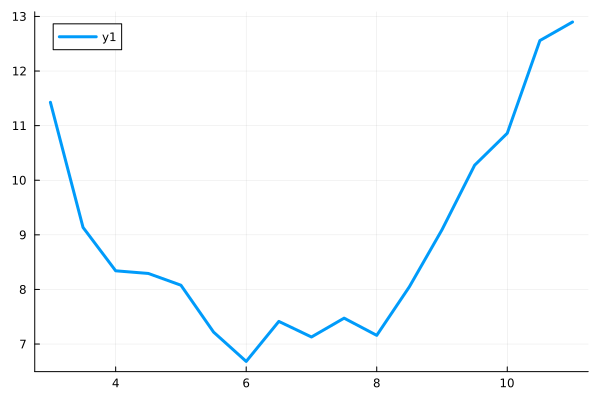

In [27]:
plot(T_depth ./ Ts, χ²_errors,
    linewidth=3,
    )

In [30]:
# χ²_errors_1 = deepcopy(χ²_errors)
# χ²_errors_2 = deepcopy(χ²_errors)
# χ²_errors_3 = deepcopy(χ²_errors)
# χ²_errors_4 = deepcopy(χ²_errors)

In [32]:
# plot(T_depth ./ Ts, χ²_errors_1,
#     linewidth=3,
#     xlabel="η",
#     ylabel="χ² error",
#     label="SF cooling",
#     box=:on,
#     title="χ² errors vs. η for release-recapture data" 
#     )
# plot!(T_depth ./ Ts, χ²_errors_2,
#     linewidth=3,
#     label="SF cooling, (100) slowing repumper off"
#     )
# plot!(T_depth ./ Ts, χ²_errors_3,
#     linewidth=3,
#     label="SF cooling, tweezer intensity PID off"
#     )
# plot!(T_depth ./ Ts, χ²_errors_4,
#     linewidth=3,
#     label="Lambda cooling"
#     )

0.00023333333333333333

0.55


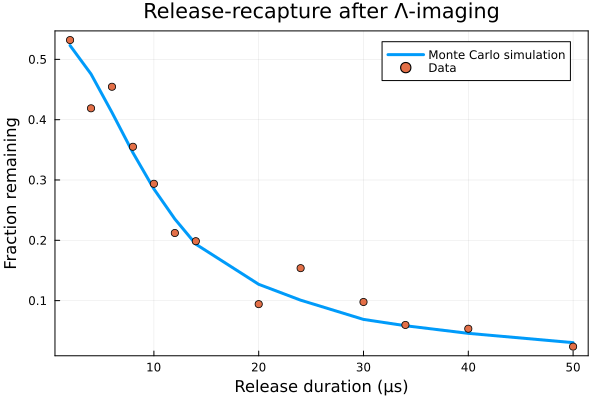

In [33]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds,
    title="Release-recapture after Λ-imaging",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [34]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds_75,
    title="Release-recapture after Λ-imaging",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
plot!(release_durations .* 1e6, best_preds_83, linewidth=3, label="Monte Carlo simulation")
plot!(release_durations .* 1e6, best_preds_90, linewidth=3, label="Monte Carlo simulation")
scatter!(data_xs_75 .* 1e6, data_ys_75, label="Data (7.5 V detuning)")
scatter!(data_xs_83 .* 1e6, data_ys_83, label="Data (8.3 V detuning)")
scatter!(data_xs_90 .* 1e6, data_ys_90, label="Data (9.0 V detuning)")

0.00023333333333333333

0.55


LoadError: UndefVarError: `best_preds_75` not defined

In [35]:
data_xs_90 = deepcopy(data_xs)
data_ys_90 = deepcopy(data_ys)
best_preds_90 = deepcopy(best_preds)
;

In [36]:
# data_xs_75 = deepcopy(data_xs)
# data_ys_75 = deepcopy(data_ys)
# best_preds_75 = deepcopy(best_preds)
# ;

In [37]:
# data_xs_83 = deepcopy(data_xs)
# data_ys_83 = deepcopy(data_ys)
# best_preds_83 = deepcopy(best_preds)
# ;

0.00023333333333333333

0.55


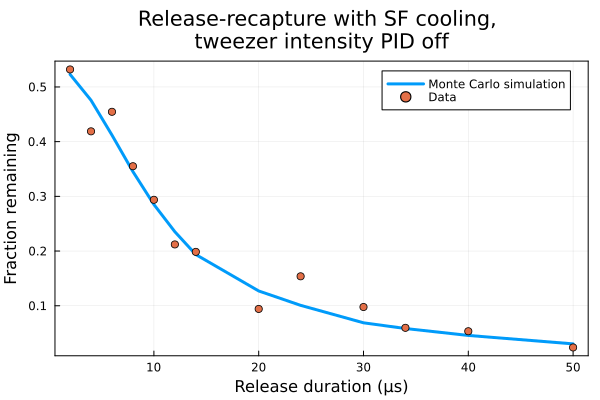

In [38]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds,
    title="Release-recapture with SF cooling, \n tweezer intensity PID off \n",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [43]:
best_preds

13-element Vector{Float64}:
 0.5229400000000001
 0.47564000000000006
 0.41195000000000004
 0.34518000000000004
 0.28512
 0.23529000000000003
 0.1936
 0.12705000000000002
 0.10076
 0.06886
 0.058410000000000004
 0.04576
 0.03036

In [39]:
using LsqFit
@. model(T, p) = p[1] * (T - p[2])^2 + p[3]

model (generic function with 1 method)

3-element Vector{Float64}:
 0.313549239627835
 6.4659181026732435
 6.975697049499437

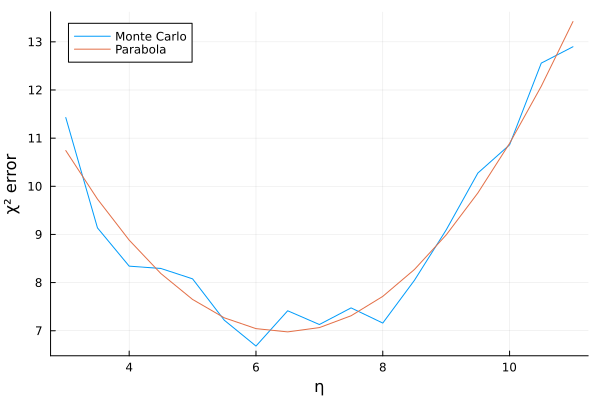

In [40]:
x = 0
y = 0

lb = [0, 0.0, 0.]
p0 = [0., 8, 0.]
ub = [1.0, 20, 20.0]
fitted_model = curve_fit(model, ηs[x+1:end-y], χ²_errors[x+1:end-y], p0, lower=lb, upper=ub)
display(fitted_model.param)
plot(ηs[x+1:end-y], χ²_errors[x+1:end-y], label="Monte Carlo", xlabel="η", ylabel="χ² error")
plot!(ηs[x+1:end-y], model(ηs[x+1:end-y], fitted_model.param), label="Parabola")

In [63]:
# The second derivative with respect to T is given by
sqrt(2 * (2fitted_model.param[1])^(-1))

1.7858588241822566

### Bootstrap model outputs to get an error range

In [ ]:
surviving_fractions

In [24]:
n = 2_000
T = 60e-6
r, v, a = make_distributions(T)

simul_xs = collect(shaved_U_depth_ratios[1]:0.01:shaved_U_depth_ratios[end])

detectable_all = zeros(n, length(simul_xs))

for (j, shaved_U_depth_ratio) ∈ enumerate(simul_xs)
    shaved_U_depth = original_U_depth * shaved_U_depth_ratio

    # Reset parameters for current run
    p.time = 0.0
    p.shaved_U_depth = shaved_U_depth

    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    detectable_all[:,j] .= s.detectable
    
end

LoadError: MethodError: no method matching make_distributions(::Float64)

[0mClosest candidates are:
[0m  make_distributions(::Any, [91m::AsymmetricGaussianTrap[39m)
[0m[90m   @[39m [36mBeamPropagation[39m [90mC:\Google Drive\github\BeamPropagation\src\[39m[90m[4mAsymmetricGaussianTrap.jl:54[24m[39m


In [25]:
n_bootstraps = 10000

surviving_fractions_lower = zeros(length(simul_xs))
surviving_fractions_upper = zeros(length(simul_xs))

for i ∈ eachindex(simul_xs)
    bootstrap_idxs = rand(1:n, n, n_bootstraps)
    bootstrap_samples = detectable_all[:,i][bootstrap_idxs]
    bootstrap_means = vec(mean(bootstrap_samples, dims=1))
    surviving_fractions_lower[i] = percentile(bootstrap_means, 50 - 34.1)
    surviving_fractions_upper[i] = percentile(bootstrap_means, 50 + 34.1)
end

LoadError: UndefVarError: `simul_xs` not defined

In [26]:
plot(simul_xs, surviving_fractions_lower, fillrange=surviving_fractions_upper, legend=nothing)

LoadError: UndefVarError: `surviving_fractions_upper` not defined

In [27]:
simul_vals = vec(mean(detectable_all, dims=1));

LoadError: UndefVarError: `detectable_all` not defined

In [28]:
simul_vals

LoadError: UndefVarError: `simul_vals` not defined

### Bootstrapping data

In [29]:
using Distributions

In [30]:
data_sampler(μs, ϵs) = [Normal(μs[i], ϵs[i]) for i ∈ eachindex(μs)]
ds = data_sampler(data_ys, data_ys_errors)
;

LoadError: UndefVarError: `data_ys_errors` not defined

In [31]:
n_bootstraps = 100_000
min_Ts = zeros(n_bootstraps)

for i ∈ 1:n_bootstraps
    bootstrap_sample = rand.(ds)
    squared_errors = vec(sum((bootstrap_sample .- surviving_fractions').^2 ./ length(data_ys), dims=1))
    _, best_idx = findmin(squared_errors)
    min_Ts[i] = Ts[best_idx]
end
histogram(min_Ts, bins=Ts)

LoadError: UndefVarError: `ds` not defined

In [32]:
mean(min_Ts)

0.0

In [33]:
percentile(min_Ts, 50 - 34.1) |> display
percentile(min_Ts, 50 + 34.1) |> display

0.0

0.0